# B1. Single time-point training

This notebook fits the entire model to 2023 data.

**To-do:**
1. Implement single time-point evaluation for 2024.
2. Wrap all spatial loops in helper functions.
3. Implement other spatial models (GWR with suitability, local GP offset model, two-parameter local GP with coefficient on prior term, etc). 
4. Write proper loop for walk-forward evaluation on all of 2024.

**Discussion points:**
1. The prior variances seem too small. I'm currently clipping them at 1/10,000. Should we clip at a higher value, e.g., 1/1000? Alternatively we could apply a constant variance inflation factor to represent our new uncertainty about the app data.
2. The migration penalty likely needs to be much smaller when training on just Helsinki, as there is much less data.
3. David suggested introducing an indicator of breeding prior quality and then fitting different models based on the indicator value. For example, if the prior breeding distribution AUC is better than 0.5 (or 0.6), then we could fit the local GP model and preserve the gaps; otherwise we fit the local GP model without the prior offsets (which reduces to the GWR model).

In [1]:
import tqdm
import pickle
import rasterio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy.stats import norm as scipy_norm

from model_utils import *
from spatial_utils import *
from eval_utils import fast_auc

#### Specify experiment parameters.

Notes:
1. Currently does not support all desired models. The GWR kernel deflated by habitat suitability is fully implemented in the spatial training loop, but commented out.
2. Downsampling code needs to be double checked.

In [2]:
# only_helsinki = True to fit to just Helsinki, False to fit to all of Finland, 
# downsample = True to fit at 1 skqm resolution, False to fit at 1 ha
# spatial_model = "GWR", "GWR_prior", "LGP" to select the spatial model
# sp = focal species name
only_helsinki = False
downsample = True
spatial_model = "GWR"
sp = "Turdus merula"

#### Prepare training XData.

In [3]:
data_path = "/scratch/project_2003104/gtikhono/bird_app/single_species/data/"
result_path = "/scratch/project_2003104/gtikhono/bird_app/single_species/results/"

with open(data_path + "XData_2023"+only_helsinki*"_helsinki"+".pickle", 'rb') as handle:
    XData = pickle.load(handle)
    
short = (XData["rec_class"] == "short").to_numpy().astype(int)
long = (XData["rec_class"] == "long").to_numpy().astype(int)
point = ((XData["rec_class"]!="short")&(XData["rec_class"]!="long")).to_numpy().astype(int)
log_duration = XData["log_duration"].to_numpy()
lats = XData["lat"].to_numpy()
lons = XData["lon"].to_numpy()
days = XData["j.date"].to_numpy()%365 # all downstream code expects days in \{1,...,365\}
ones = np.ones(XData.shape[0])

#### Prepare training species data.

In [4]:
sp_lower = sp.lower().replace(" ", "_").split(".")[0]
sp_dir = data_path + sp_lower + "/"
with open(data_path + "migration_prior_params.pickle", 'rb') as handle:
    prior_m_params = pickle.load(handle)
prior_m_params = prior_m_params.loc[sp_lower][:6].to_numpy()

with open(sp_dir + sp_lower+"_2023_"+only_helsinki*"helsinki_"+"prior.pickle", 'rb') as handle:
    species = pickle.load(handle)

species["prior.s.L"] = pd.Series(scipy_norm.ppf(species["prior.s"]), index=species["prior.s"].index)
if species["prior.s.L"].isna().any() or species["prior.s.L"].isin([np.inf, -np.inf]).any():
    print("NaNs or infs introduced when mapping s -> \Phi^{-1}(s)")
    
y = species["y"].to_numpy()
prior_s = species["prior.s"].to_numpy()
prior_m = species["prior.m"].to_numpy()
prior_d = species["prior.d"].to_numpy()
prior_d_b = species["prior.d.b"].to_numpy()
prior_sL = species["prior.s.L"].to_numpy()
u = (species["prior.d.u"]==0).to_numpy()
complete = species["complete"].to_numpy()

tmp_preds = prior_m*prior_s*prior_d
print("AUC from prior (in-sample):", np.round(fast_auc(y[complete], tmp_preds[complete]),3))

AUC from prior (in-sample): 0.66


#### Prepare prior maps and align with XData.

Critically assumes that `_va.tif` contains variances on the probability scale. The `_va.tif` maps that O2 sent previously were on the linear scale - these should **not** be provided as inputs, and must be converted to the correct scale in preprocessing.

In [5]:
with rasterio.open(sp_dir+sp_lower+"_a.tif") as src:
    a_map = src.read(1) 
    transform = src.transform
    height, width = src.height, src.width 
    
with rasterio.open(sp_dir+sp_lower+"_va.tif") as src:
    va_map = src.read(1) 
va_map[(np.isnan(va_map))&(~np.isnan(a_map))] = 1.0 # ensure a_map != nan implies va_map != nan
va_map[np.isnan(a_map)] = np.nan
va_map = np.clip(va_map, 1e-4, 1) # clip very small variances to avoid numerical issues with precision
    
if downsample:
    print("downsampling not tested")
    #
    # not tested, no idea if this works
    # might need transform.scale(1/factor, 1/factor)
    #
    factor = 10
    new_height = height//factor
    new_width = width//factor

    a_map = a_map[:new_height*factor, :new_width*factor]
    a_map = a_map.reshape(new_height, factor, new_width, factor)
    a_map = np.nanmean(a_map, axis=(1, 3))

    va_map = va_map[:new_height*factor, :new_width*factor]
    va_map = va_map.reshape(new_height, factor, new_width, factor)
    va_map = np.nanmean(va_map, axis=(1, 3))

    transform = transform*transform.scale(factor, factor)
    height = new_height
    width = new_width
    
ys = np.arange(height)
_, lat_grid = rasterio.transform.xy(transform, ys, np.zeros_like(ys))
lat_grid = np.array(lat_grid)

xs = np.arange(width)
lon_grid, _ = rasterio.transform.xy(transform, np.zeros_like(xs), xs)
lon_grid = np.array(lon_grid)

lons_clipped = lons.clip(lon_grid[0], lon_grid[-1])
lats_clipped = lats.clip(lat_grid[-1], lat_grid[0])
rows_to_grid = rasterio.transform.rowcol(transform, lons_clipped, lats_clipped)

downsampling not tested


/tmp/gtikhono/27114964/ipykernel_2930326/1279981188.py:24: RuntimeWarning: Mean of empty slice
  a_map = np.nanmean(a_map, axis=(1, 3))
/tmp/gtikhono/27114964/ipykernel_2930326/1279981188.py:28: RuntimeWarning: Mean of empty slice
  va_map = np.nanmean(va_map, axis=(1, 3))


Verify alignment before model fitting. This is important because all models take arrays as inputs and make no attempt to match on indexes.

In [6]:
print("XData index matches species index:", (species.index == XData.index).all())

XData index matches species index: True


## Fit Detection Model
GT: this uses 2+ cores.

GT: this stops after 200 iterations. Early stopping criteria shall be adjusted?

In [10]:
beta_mean =  np.array([-2.0, -2.0, 1.0, 0.0, 0.0])
beta_prec = 1/100.0

tau_detection = prior_m*prior_d
X_detection = np.c_[ones*short, ones*long, prior_sL, short*log_duration, long*log_duration, point]
beta = fit_detection_model(y[complete], X_detection[complete,:5], tau_detection[complete,],
                           beta_mean, beta_prec)
point_intercept = (beta[0] + beta[1] + (beta[3] + beta[4])*np.log(300))/2 # irrelevant for 2023 but needed for 2024
beta = np.append(beta, point_intercept)
post_s = scipy_norm.cdf(X_detection@beta)

tmp_preds = post_s*tau_detection
print("AUC after updating detection (in-sample):", np.round(fast_auc(y[complete], tmp_preds[complete]),3))


raining detection model:   2%|▏         | 199/10000 [00:19<16:02, 10.18it/s]

AUC after updating detection (in-sample): 0.703


## Fit Migration Model

**TO-DO:** The grid for the penalty is currently hardcoded in the utils file. Modify to specify grid in this document instead.

GT: this uses 2+ cores.

GT: stops after 200 iterations.

In [11]:
theta_prec = 1/100.0

if np.var(prior_m) == 0:
    print("Migration model has no variance; skipping resident species.")
    post_m = prior_m
    theta = prior_m_params
else:
    tau_migration = post_s*prior_d
    theta = fit_migration_model(y[complete], lats[complete], days[complete], tau_migration[complete], 
                                prior_m_params, theta_prec)
    post_m = m_numpy(lats, days, theta)

    tmp_preds = post_m*tau_migration
    print("AUC after updating migration (in-sample):", np.round(fast_auc(y[complete], tmp_preds[complete]),3))


raining migration model:   2%|▏         | 199/10000 [00:32<26:55,  6.07it/s]

AUC after updating migration (in-sample): 0.726


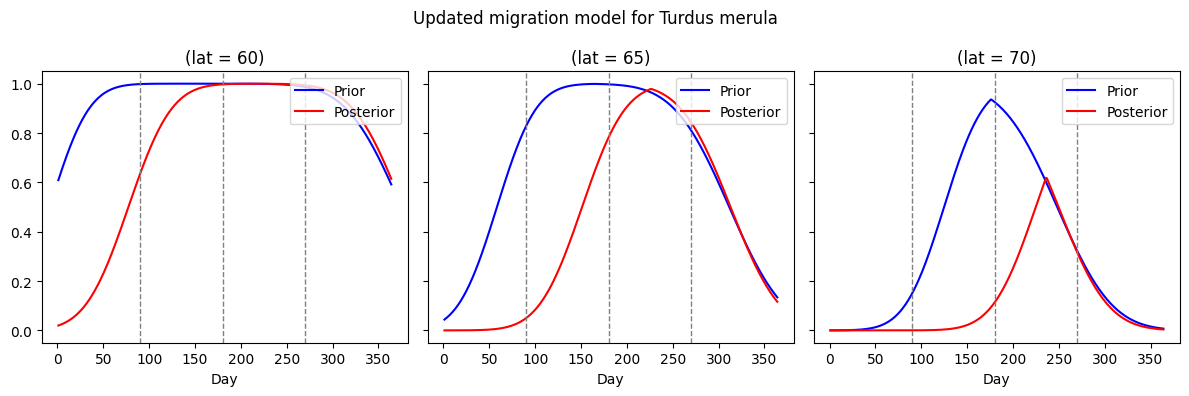

In [12]:
test_lats = [60, 65, 70]
test_days = range(1, 365)
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for i, test_lat in enumerate(test_lats):
    m_func_prior = m_numpy(test_lat, test_days, prior_m_params)
    m_func_post = m_numpy(test_lat, test_days, theta)
    ax[i].plot(test_days, m_func_prior, color="blue", label="Prior");
    ax[i].plot(test_days, m_func_post, color="red", label="Posterior");
    ax[i].set_title("(lat = " + str(test_lat) + ")");
    ax[i].legend(loc="upper right")
    ax[i].set_xlabel("Day")
    ax[i].axvline(90, color="grey", linestyle="dashed", linewidth=1)
    ax[i].axvline(180, color="grey", linestyle="dashed", linewidth=1)
    ax[i].axvline(270, color="grey", linestyle="dashed", linewidth=1)
plt.suptitle("Updated migration model for " + sp);
plt.tight_layout()

## Fit Spatial Model

In [13]:
cell_idx = np.arange(height*width).reshape(height, width)
prior_map = DistributionMap(cell_idx=cell_idx, lat_grid=lat_grid, lon_grid=lon_grid,
                            mean_map=a_map, var_map=va_map)
post_map = DistributionMap(cell_idx=prior_map.cell_idx, lat_grid=prior_map.lat_grid, lon_grid=prior_map.lon_grid,
                            mean_map=prior_map.mean_map.copy(), var_map=prior_map.var_map.copy())

**@Gleb - the loop below benefits massively from parallelization. It would also be convenient to save the data_map for the 2023 data across all of Finland so we can rapidly test multiple models.**

The loops below will eventually be moved to `spatial_utils`, but are left here for convenience while parallelizing.

GT: this uses 1 core.

In [14]:
Y_dict = {}
threshold_dict = {}
has_data = np.zeros([prior_map.height, prior_map.width]).astype(bool)

# rows_to_grid is from rasterio.transform.rowcol(transform, XData["lon"], XData["lat"])
tau_spatial = post_s*post_m
rows_to_idx = prior_map.cell_idx[rows_to_grid]
cells_with_data = np.unique(rows_to_idx)

for c in tqdm.tqdm(cells_with_data):
    sel = (rows_to_idx==c)*complete*u
    if np.any(sel):
        row = c//prior_map.width
        col = c%prior_map.width
        has_data[row, col] = True
        Y_dict[c] = y[sel]
        threshold_dict[c] = tau_spatial[sel]
        
has_data = has_data.flatten()
data_map = DataMap(Y_dict = Y_dict, threshold_dict = threshold_dict, has_data = has_data)


00%|██████████| 117327/117327 [08:49<00:00, 221.57it/s]

The GWR variance is a new feature based on the calculation that if
$$
f(d) = \sum_{i} w_i [y_i\log(\tau_i a) + (1-y_i)\log(1-\tau_i a)]
$$
then
$$
f''(d) = -\sum_i w_i\frac{y_i - 2 d y_i \tau_i + d^2 \tau_i^2}{d^2 (1 - d \tau_i)^2}.
$$

**Important to be careful with tracking precision/variances.**

**@Gleb - this is the other main loop to optimize.**

GT: this one is quite unstable - it sometimes uses more than 1 core, but most time just 1.

In [15]:
r_nh = 5
r_kernel = 2.5
cells_to_update = prior_map.cell_idx[~np.isnan(prior_map.mean_map)]

if only_helsinki:
    lat_min_hel_idx = binary_search_dec(prior_map.lat_grid, 60)
    lat_max_hel_idx = binary_search_dec(prior_map.lat_grid, 60.5)
    lon_min_hel_idx = binary_search_inc(prior_map.lon_grid, 24.5)
    lon_max_hel_idx = binary_search_inc(prior_map.lon_grid, 25.5)
    cells_in_helsinki = prior_map.cell_idx[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx].flatten()
    cells_to_update = np.intersect1d(cells_to_update, cells_in_helsinki)
    
for c0 in tqdm.tqdm(cells_to_update, desc="Fitting spatial model"):
    row = c0//prior_map.width
    col = c0%prior_map.width
    prior_mean = prior_map.mean_map[row, col]
    prior_prec = 1/prior_map.var_map[row, col] # convert to precision
    
    neighborhood = prior_map.get_nearby_cells(c0, r_nh)
    cells_to_use = neighborhood[data_map.has_data[neighborhood]]
    
    if len(cells_to_use) == 0:
        continue
        
#     teasy to replace kernels with \lambda^{|d(c) - d(c_0)|}K(c, c_0),
#     we would first extract the prior values in the neighborhood
#     then calculate the scaling factor \lambda^{\delta prior}
#     then broadcast with cell_weights
    
#     cell_weights = ...
    
#     lam = 0.9
#     prior_in_neighborhood = prior_map.mean_map[cells_to_use//prior_map.width, cells_to_use%prior_map.width]
#     delta_prior = np.abs(prior_map.mean_map[row, col] - prior_in_neighborhood)
#     deflation = np.power(lam, delta_prior)
#     cell_weights = cell_weights*deflation
    
#     weights_train = ...
    Y_train, n_train, threshold_train = data_map.pool_data(cells_to_use)
    cell_weights = prior_map.calculate_kernel(c0, cells_to_use, r_kernel)    
    weights_train = np.repeat(cell_weights, n_train)
    
    result = fit_GWR(Y_train, threshold_train, weights_train, prior_mean, prior_prec)
    post_map.mean_map[row, col] = result["mean"]
    post_map.var_map[row, col] = result["variance"]
    
post_d_a = post_map.mean_map.flatten()[rows_to_idx]
post_d = post_d_a + (1-post_d_a)*u*prior_d_b
tmp_preds = post_s*post_m*post_d
idx = ~np.isnan(tmp_preds)
print("AUC after updating spatial model (in-sample):", np.round(fast_auc(y[idx], tmp_preds[idx]),3))


/tmp/gtikhono/27114964/ipykernel_2930326/2735792475.py:48: RuntimeWarning: invalid value encountered in multiply
  post_d = post_d_a + (1-post_d_a)*u*prior_d_b


AUC after updating spatial model (in-sample): 0.763


**TO-DO:** modify so file names are consistent with the outputs of preprocessing.

In [20]:
final = {}
final["only_helsinki"] = only_helsinki
final["downsample"] = downsample
final["spatial_model"] = spatial_model
final["sp"] = sp
final["beta"] = beta
final["theta"] = theta
final["posterior"] = post_map
with open(result_path+sp_lower+"_2023_results.pickle", "wb") as handle:
    pickle.dump(final, handle, protocol=pickle.HIGHEST_PROTOCOL)

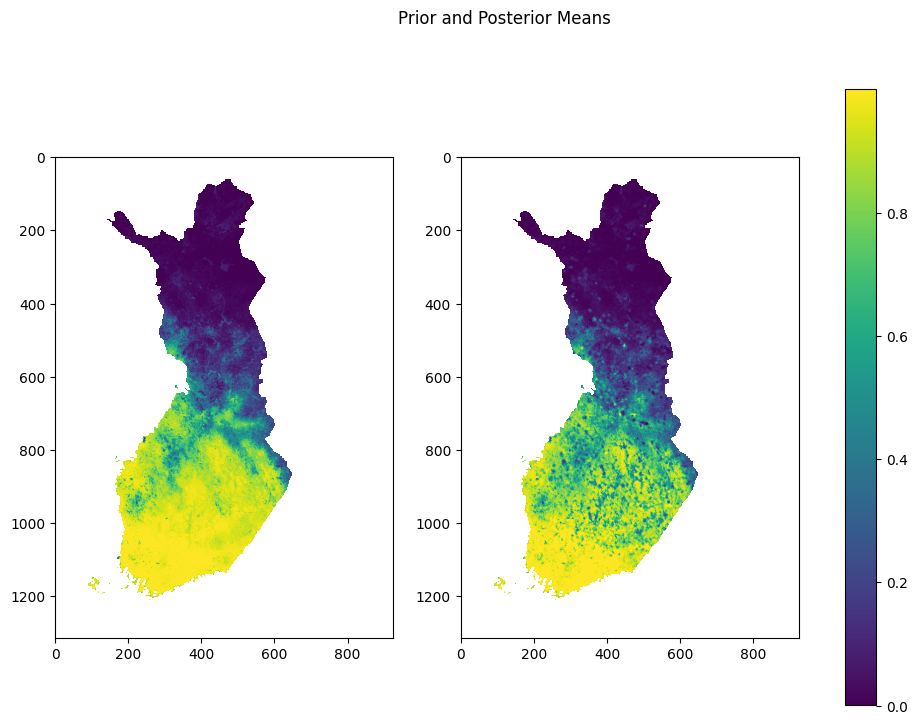

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12, 8))
if only_helsinki:
    ax[0].imshow(prior_map.mean_map[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx], vmin=0, vmax=1)
    im = ax[1].imshow(post_map.mean_map[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx])
else:
    ax[0].imshow(prior_map.mean_map)
    im = ax[1].imshow(post_map.mean_map)
fig.colorbar(im, ax=ax);
plt.suptitle("Prior and Posterior Means");

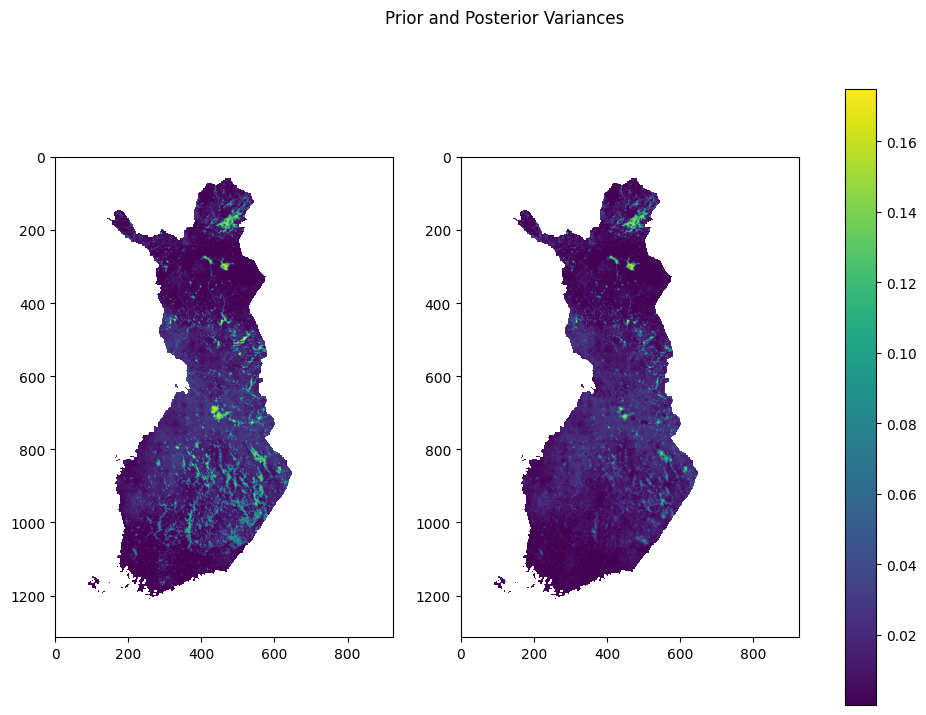

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12, 8))
if only_helsinki:
    ax[0].imshow(prior_map.var_map[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx])
    im = ax[1].imshow(post_map.var_map[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx])
else:
    ax[0].imshow(prior_map.var_map)
    im = ax[1].imshow(post_map.var_map)
fig.colorbar(im, ax=ax);
plt.suptitle("Prior and Posterior Variances");

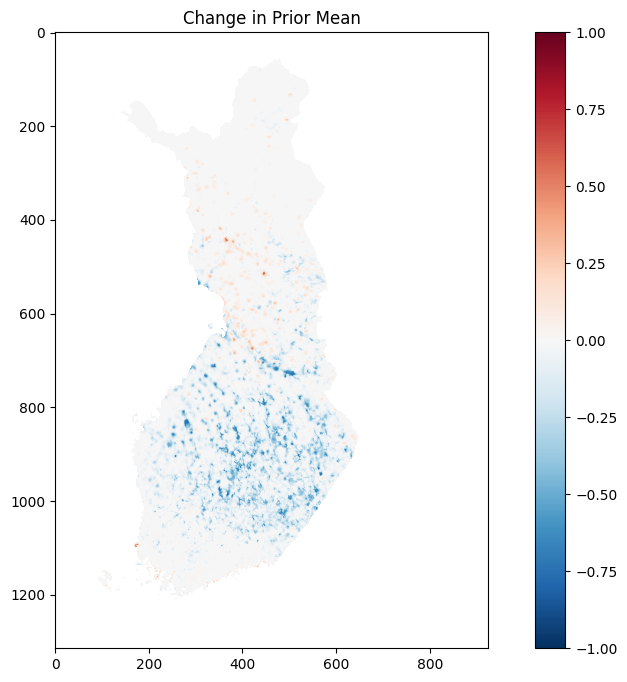

In [23]:
delta_mean = post_map.mean_map - prior_map.mean_map
if only_helsinki:
    delta_mean = delta_mean[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx]
    
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(delta_mean, cmap="RdBu_r", vmin=-1, vmax=1)
fig.colorbar(im, ax=ax);
plt.title("Change in Prior Mean");

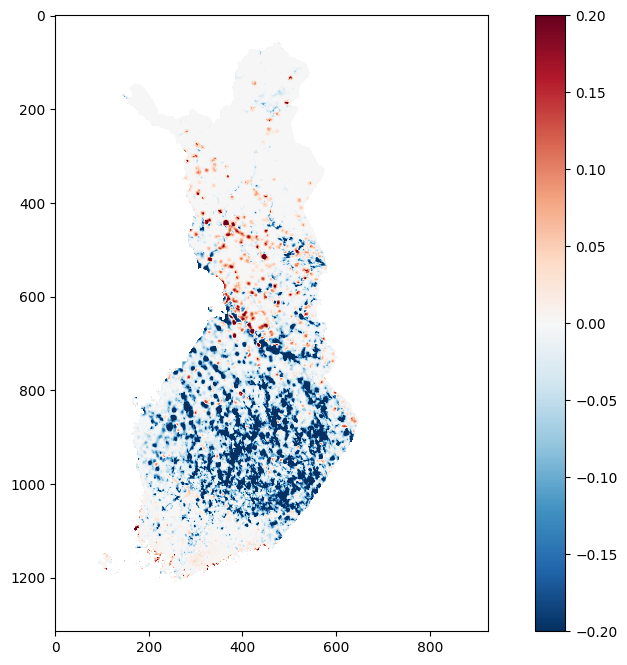

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(delta_mean, cmap="RdBu_r", vmin=-0.2, vmax=0.2)
fig.colorbar(im, ax=ax);

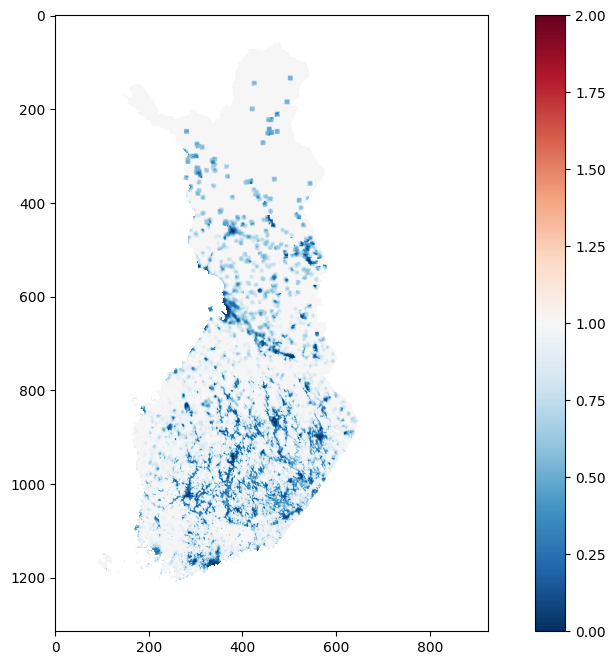

In [25]:
ratio_var = post_map.var_map/prior_map.var_map
if only_helsinki:
    ratio_var = ratio_var[lat_max_hel_idx:lat_min_hel_idx, lon_min_hel_idx:lon_max_hel_idx]
    
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(ratio_var, cmap="RdBu_r", vmin=0, vmax=2)
fig.colorbar(im, ax=ax);